# Tectonic subsidence from backstripping

In this example we backstrip stratigraphic layers at a shallow continental drill site location and use the recorded paleo-water depths to reveal tectonic subsidence.


## Reference

The following paper covers the theory and algorithms of pyBacktrack:

* Müller, R. D., Cannon, J., Williams, S. and Dutkiewicz, A., 2018,
  PyBacktrack 1.0: A Tool for Reconstructing Paleobathymetry on Oceanic and Continental Crust,
  **Geochemistry, Geophysics, Geosystems,** 19, 1898-1909, doi: [10.1029/2017GC007313](https://doi.org/10.1029/2017GC007313)

## Locations of NW Shelf wells

The well names and associated locations are read from a file and then plotted with a topography/bathymetry background image.

In [1]:
# Function to read well names and locations.
# Returns a dictionary mapping names to (latitude, longitude) location tuples.
def read_well_locations_file(well_locations_filename):
    well_locations = {}
    
    with open(well_locations_filename, 'r') as well_locations_file:
        # Skip the header line.
        well_locations_file.readline()
        
        while True:
            header_line = well_locations_file.readline()
            if not header_line:
                # EOF.
                break
            
            # There can be spaces in the well name, but there's also text after the well name (on same line).
            # Currently it looks like:
            #  * For those lines containing only spaces, the well name does not go past a certain column.
            #  * For those lines containing some tabs, the well name is the part before the first tab.
            well_name = header_line.split('\t', 1)[0][1:17].strip().lower()
            # Remove numbers at end of well names.
            if well_name[-1] == '1' or well_name[-1] == '2' or well_name[-1] == '3':
                well_name = well_name[0:-1]
                if well_name[-1] == ' ' or well_name[-1] == '-':
                    well_name = well_name[0:-1]
            
            data_line = well_locations_file.readline()
            data = data_line.split()
            
            well_location = float(data[0]), float(data[1])
            well_locations[well_name] = well_location
    
    return well_locations

# Get a dictionary mapping names to locations for all available wells.
well_locations = read_well_locations_file('../example_data/NW_shelf_well_locations.lst')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_well_locations(
        well_locations,
        min_longitude,
        max_longitude,
        min_latitude,
        max_latitude,
        well_label_font_size):
    
    plt.figure(figsize=(20,20))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title('NW Shelf wells', fontsize=16)
    
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Region of map to show.
    ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude])

    # Topography/bathymetry background.
    topography_image = plt.imread('../example_data/NW_shelf_topography.png')
    topography_image_extent=[90,135,-45,0]
    ax.imshow(topography_image, origin='upper', extent=topography_image_extent, transform=ccrs.PlateCarree())

    # Coastlines.
    ax.coastlines(resolution='50m')

    # Plot each well location, and label with well name.
    well_names = well_locations.keys()
    for well_name in well_names:
        well_latitude, well_longitude = well_locations[well_name]
        # Only plot well if it's inside the region we're showing.
        if (well_latitude >= min_latitude and well_latitude <= max_latitude and
            well_longitude >= min_longitude and well_longitude <= max_longitude):
            ax.plot(well_longitude, well_latitude, 'ko', markersize=3, transform=ccrs.Geodetic())
            ax.text(well_longitude, well_latitude, well_name, transform=ccrs.Geodetic(), fontsize=well_label_font_size)

    plt.show()

E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\cartopy\mpl\gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\cartopy\mpl\gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


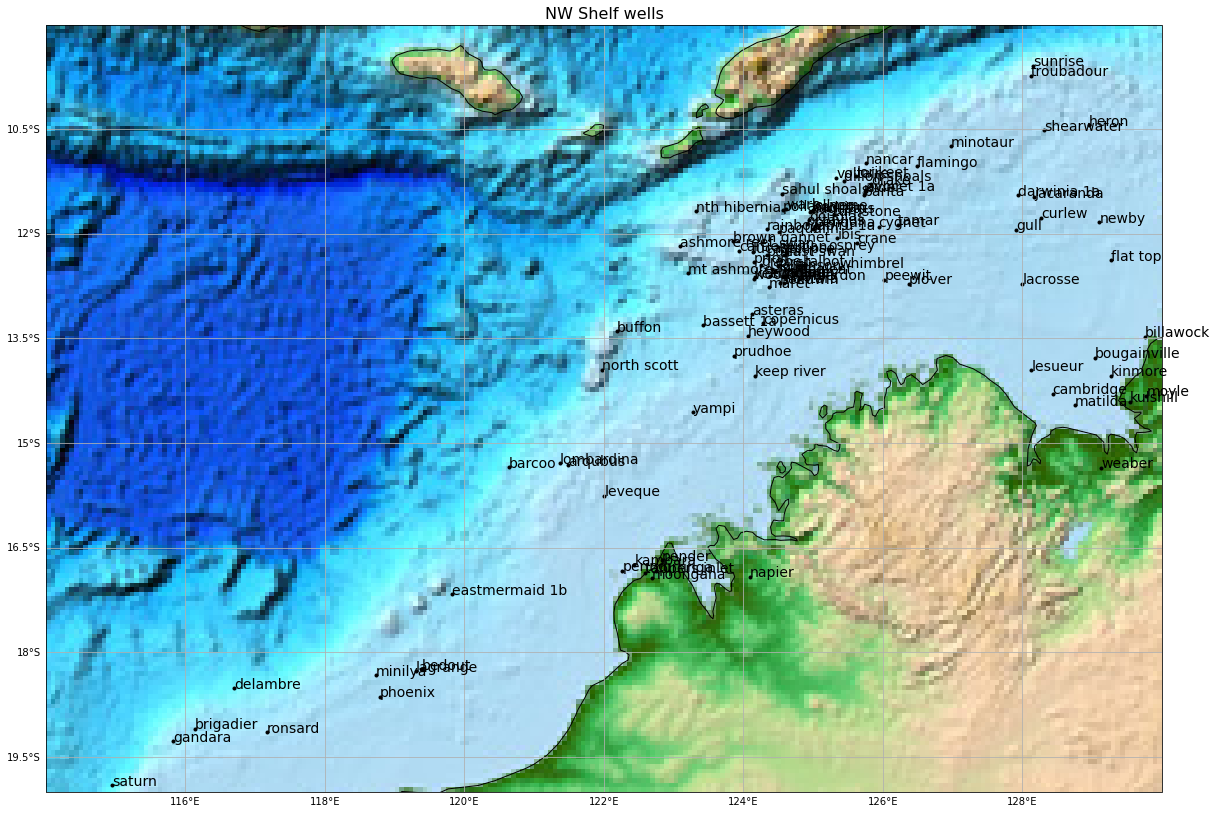

In [3]:
plot_well_locations(
    well_locations,
    min_longitude=114, max_longitude=130, min_latitude=-20, max_latitude=-9,
    well_label_font_size=14)

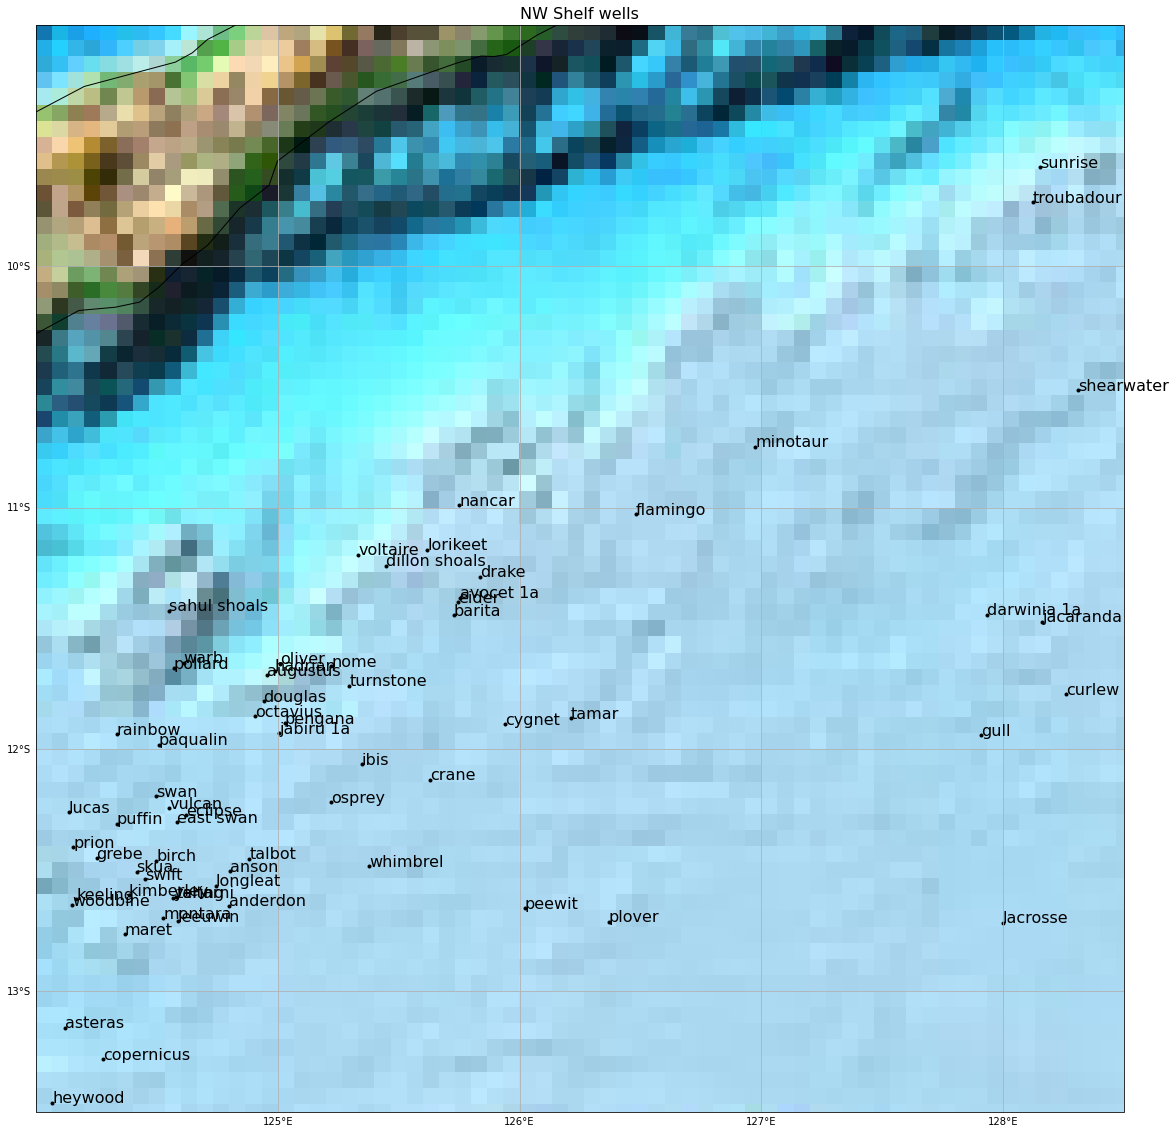

In [4]:
plot_well_locations(
    well_locations,
    min_longitude=124, max_longitude=128.5, min_latitude=-13.5, max_latitude=-9,
    well_label_font_size=16)

## Analyze a particular well

Here we select a particular well for backstripping.

In [5]:
import pybacktrack

#
# Each drill site file specifies then depths, ages and lithologies of its stratigraphic layers.
#
# A shallow continental drill site file used with backstripping.
backstrip_well_filename = '../example_data/sunrise_lithology.txt'

In [6]:
import warnings

# Ignore user warnings related to well thickness being larger than total sediment thickness.
#
# This happens because the default total sediment thickness grid is not as accurate near continental margins
# like the 'sunrise' drill site (compared to deeper ocean basins).
warnings.filterwarnings("ignore", "Well thickness .* is larger than the total sediment thickness")

# Ignore user warnings related to dynamic topography sampling.
#
# This happens when the age of interpolated dynamic topography grids are older than the crust at the drill site location.
warnings.filterwarnings("ignore", "Dynamic topography model .* cannot")

## Function to plot tectonic subsidence showing paleo-water depth uncertainty

Here we plot tectonic subsidence versus age. At the age of each stratigraphic layer an error bar is displaying showing the uncertainty in tectonic subsidence due to the uncertainty in recorded paleo-water depths in the drill site (each layer has a minimum and maximum water depth).

In [7]:
def plot_tectonic_subsidence(
        decompacted_sections,
        plot_sea_level=False,
        dynamic_topography_model=None,
        gforisos_output=None,
        plot_subsidence_minus_dynamic_topography=False):

    # 'decompacted_sections' is a list of pybacktrack.DecompactedWell.
    # Each decompacted section is a single pybacktrack.DecompactedWell that represents
    # the stratigraphic section of the well when it is decompacted at a particular time
    # (the time of one of its stratigraphic units).
    #
    # Extract the age and tectonic subsidence from each decompacted section in the list.
    ages = [decompacted_section.get_age()
            for decompacted_section in decompacted_sections]
    tectonic_subsidences = [decompacted_section.get_tectonic_subsidence()
            for decompacted_section in decompacted_sections]
    min_max_tectonic_subsidences = [decompacted_section.get_min_max_tectonic_subsidence()
            for decompacted_section in decompacted_sections]
    tectonic_subsidence_uncertainties = [0.5 * (max_tectonic_subsidence - min_tectonic_subsidence)
            for min_tectonic_subsidence, max_tectonic_subsidence in min_max_tectonic_subsidences]
    
    if plot_sea_level:
        # Keep track of the sea level (relative to present day) at each age.
        #
        # NOTE: Positive values represent sea-level rise which is the opposite of depth
        # (which is positive going down).
        # So we need to negate sea level to turn a rise into a depth.
        sea_level_depths = [-decompacted_section.get_sea_level()
                for decompacted_section in decompacted_sections]
    
    if dynamic_topography_model:
        # Keep track of the dynamic topography at each age.
        #
        # NOTE: Positive values represent elevation which is the opposite of subsidence
        # (which is positive going down).
        # So we need to negate dynamic topography to turn an elevation into a depth.
        dynamic_topography_depths = [-dynamic_topography_model.sample(decompacted_section.get_age())
                for decompacted_section in decompacted_sections]

    fig = plt.figure(figsize=(8,8))

    # Plot tectonic subsidence.
    plt.errorbar(
        ages,
        tectonic_subsidences,
        yerr=tectonic_subsidence_uncertainties,
        fmt='-o',
        color='black',
        label='tectonic subsidence',
        linestyle='-',
        linewidth=2.0)

    if plot_sea_level:
        # Plot sea level.
        plt.plot(
            ages,
            sea_level_depths,
            color='blue',
            label='sea level',
            linestyle='-',
            linewidth=2.0)

    if dynamic_topography_model:
        # Plot dynamic topography.
        plt.plot(
            ages,
            dynamic_topography_depths,
            color='red',
            label='dynamic topography',
            linestyle='-',
            linewidth=2.0)
    
    if plot_subsidence_minus_dynamic_topography:
        # Plot tectonic subsidence minus dynamic topography.
        plt.errorbar(
            ages,
            [(tectonic_subsidences[age_index] - dynamic_topography_depths[age_index])
                 for age_index in range(len(ages))],
            yerr=tectonic_subsidence_uncertainties,
            fmt='-o',
            color='magenta',
            label='tectonic subsidence rel. dynamic topography',
            linestyle='-',
            linewidth=2.0)
    
    if gforisos_output:
        for beta_index, (gforisos_ages, gforisos_subsidences) in enumerate(gforisos_output):
            # Plot tectonic subsidence output by gforisos program (for a specific BETA).
            plt.plot(
                gforisos_ages,
                gforisos_subsidences,
                color='green',
                label='gforisos subsidence {0}'.format(beta_index+1),
                linestyle='-',
                linewidth=2.0)

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.ylabel('Depth (m)', fontsize=12)
    plt.xlabel('Age (Ma)', fontsize=12)
    plt.grid(linestyle='--',alpha=0.5)

    plt.legend(fontsize=10)

    plt.show()

## Calculate tectonic subsidence and show paleo-water depth uncertainty

Here we use the [pybacktrack.backstrip_well](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.backstrip_well) function to find the tectonic subsidence for each age in the well site. It returns a list of [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell) and from each one we extract an age and a tectonic subsidence.

Note that each [pybacktrack.DecompactedWell](https://pybacktrack.readthedocs.io/en/latest/pybacktrack_reference.html#pybacktrack.DecompactedWell) represents the stratigraphic section of the well when it is decompacted at a particular time (the time of one of its stratigraphic units).

E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\ipykernel_launcher.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.


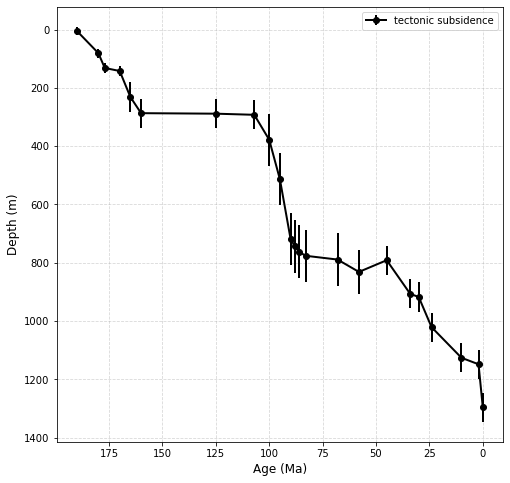

In [8]:
# Backstrip to find the tectonic subsidence for each age in the well site.
well, decompacted_sections = pybacktrack.backstrip_well(
    backstrip_well_filename,
    pybacktrack.BUNDLE_LITHOLOGY_FILENAMES)

plot_tectonic_subsidence(decompacted_sections)

## Calculate tectonic subsidence using a global sea level curve

Here we calculate tectonic subsidence again, but this time also using a sea level model.

E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\ipykernel_launcher.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.


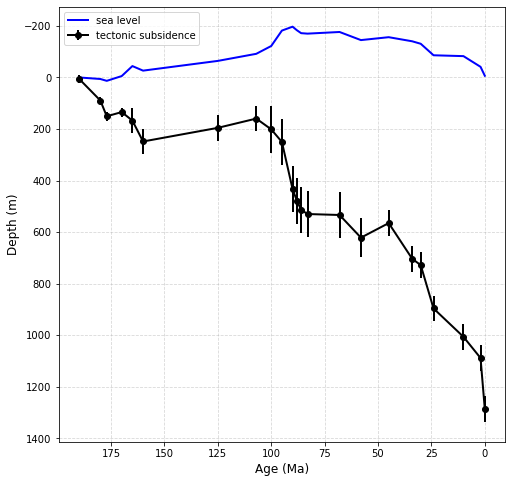

In [9]:
# Backstrip to find the tectonic subsidence for each age in the well site.
#
# But also include the built-in 'Haq87_SealevelCurve_Longterm' sea level model. 
well, decompacted_sections = pybacktrack.backstrip_well(
    backstrip_well_filename,
    pybacktrack.BUNDLE_LITHOLOGY_FILENAMES,
    sea_level_model='Haq87_SealevelCurve_Longterm')

plot_tectonic_subsidence(decompacted_sections, plot_sea_level=True)

## Show dynamic topography model 'M6'

Here we also plot the dynamic topography model 'M6' built into pyBacktrack. For all built-in dynamic topography models see http://portal.gplates.org/portal/dt/.

**Note:** Dynamic topography is not affecting the tectonic subsidence here, we're just plotting dynamic topography alongside tectonic subsidence.

E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\ipykernel_launcher.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.


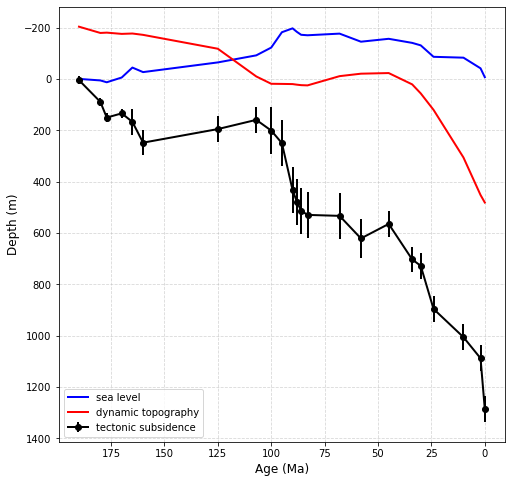

In [10]:
dynamic_topography_model_M6 = pybacktrack.DynamicTopography.create_from_bundled_model(
    'M6', well.longitude, well.latitude)

plot_tectonic_subsidence(
    decompacted_sections,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M6)

## Show dynamic topography model 'M7'

Here we plot the dynamic topography model 'M7'.

E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\ipykernel_launcher.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.


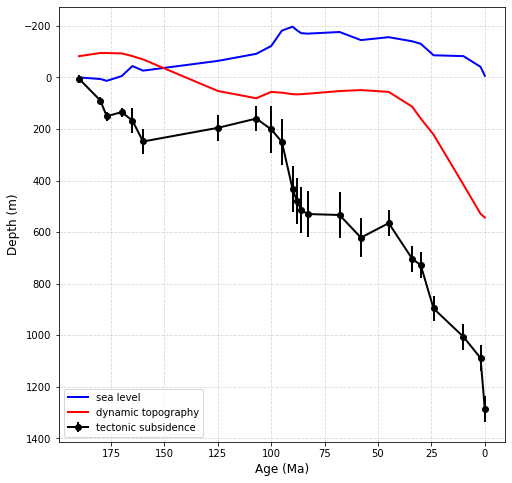

In [11]:
dynamic_topography_model_M7 = pybacktrack.DynamicTopography.create_from_bundled_model(
    'M7', well.longitude, well.latitude)

plot_tectonic_subsidence(
    decompacted_sections,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M7)

## Subtract dynamic topography from tectonic subsidence

Here we also plot the tectonic subsidence with dynamic topography subtracted. This shows subsidence relative to dynamic topography.

E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\ipykernel_launcher.py:52: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
E:\Apps\miniconda3\envs\pybacktrack_py37\lib\site-packages\ipykernel_launcher.py:85: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.


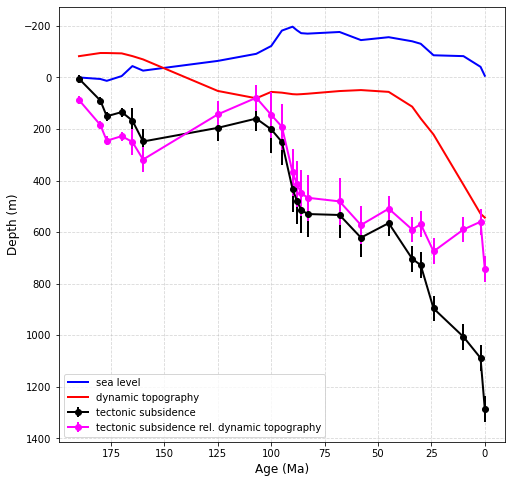

In [12]:
plot_tectonic_subsidence(
    decompacted_sections,
    plot_sea_level=True,
    dynamic_topography_model=dynamic_topography_model_M7,
    plot_subsidence_minus_dynamic_topography=True)